<a href="https://colab.research.google.com/github/sychun/colab/blob/master/h_nn_gan_c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers


import matplotlib.pyplot as plt

import sys

import numpy as np
import tqdm


In [2]:
# Set the seed for reproducible result
np.random.seed(1000)

randomDim = 10 # 10차원
# Load MNIST data
(X_train, _), (_, _) = mnist.load_data() # _ 은 placeholder 역할. 데이터는 받드라도 사용 않겠다
X_train = (X_train.astype(np.float32) - 127.5)/127.5 # -1.0 에서 1.0 사이로...
X_train = X_train.reshape(60000, 784) # 완전연결망


11493376/11490434 [==============================] - 0s 0us/step


In [3]:
X_train[0].min(), X_train[0].max()

(-1.0, 1.0)

In [4]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

generator = Sequential()
generator.add(Dense(256, input_dim=randomDim)) #, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh')) # 마지막 층의 출력은 원본 크기와 같게
#generator.compile(loss='binary_crossentropy', optimizer=adam)



In [5]:
# discriminator도 완전연결망

discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid')) # 마지마은 0, 1로 구분하려고
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

In [7]:
# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

dLosses = []
gLosses = []

In [8]:
gan.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               1463312   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1460225   
Total params: 2,923,537
Trainable params: 1,463,312
Non-trainable params: 1,460,225
_________________________________________________________________


In [9]:
# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def saveGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/gan_generated_image_epoch_%d.png' % epoch)

In [10]:
!mkdir images

In [11]:
def train(epochs=1, batchSize=128):
    batchCount = int(X_train.shape[0] / batchSize) # epoch당 반복 회수
    print ('Epochs:', epochs)
    print ('Batch size:', batchSize)
    print ('Batches per epoch:', batchCount)

    for e in range(1, epochs+1): # epoch 반복
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):
            # Get a random set of input noise and "original" images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise) # 생성(조작)된 이미지
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages]) # 원본 + 조작 이미지

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9 # 원래 0과 1을 주어야 하는데 가변성을 감안해서 0.9로

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis) # online 학습. 기준 가중치를 유지하면서 새로운 데이터로 학습

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize) # 1을 주어, 속임수
            discriminator.trainable = False # 판단 기준을 고정 시킴
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e % 20 == 0:
            saveGeneratedImages(e)
            

    # Plot losses from every epoch
    plotLoss(e)

Epochs: 50
Batch size: 128
Batches per epoch: 468
--------------- Epoch 1 ---------------
--------------- Epoch 2 ---------------
--------------- Epoch 3 ---------------
--------------- Epoch 4 ---------------
--------------- Epoch 5 ---------------
--------------- Epoch 6 ---------------
--------------- Epoch 7 ---------------
--------------- Epoch 8 ---------------
--------------- Epoch 9 ---------------
--------------- Epoch 10 ---------------
--------------- Epoch 11 ---------------
--------------- Epoch 12 ---------------
--------------- Epoch 13 ---------------
--------------- Epoch 14 ---------------
--------------- Epoch 15 ---------------
--------------- Epoch 16 ---------------
--------------- Epoch 17 ---------------
--------------- Epoch 18 ---------------
--------------- Epoch 19 ---------------
--------------- Epoch 20 ---------------
--------------- Epoch 21 ---------------
--------------- Epoch 22 ---------------
--------------- Epoch 23 ---------------
--------------- 

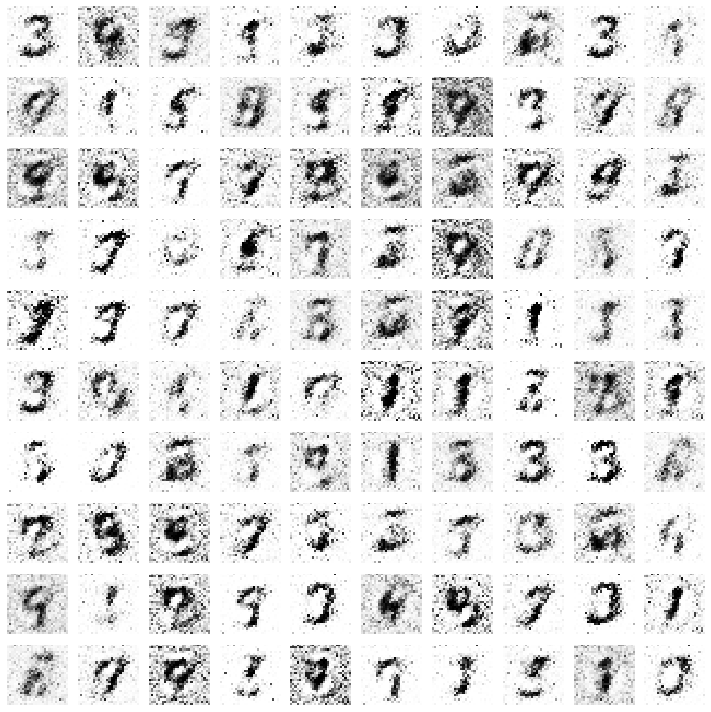

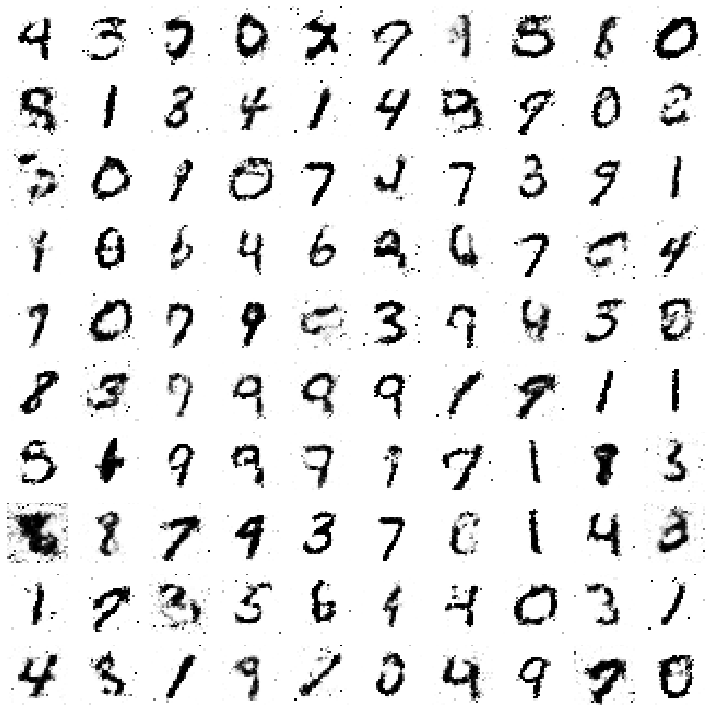

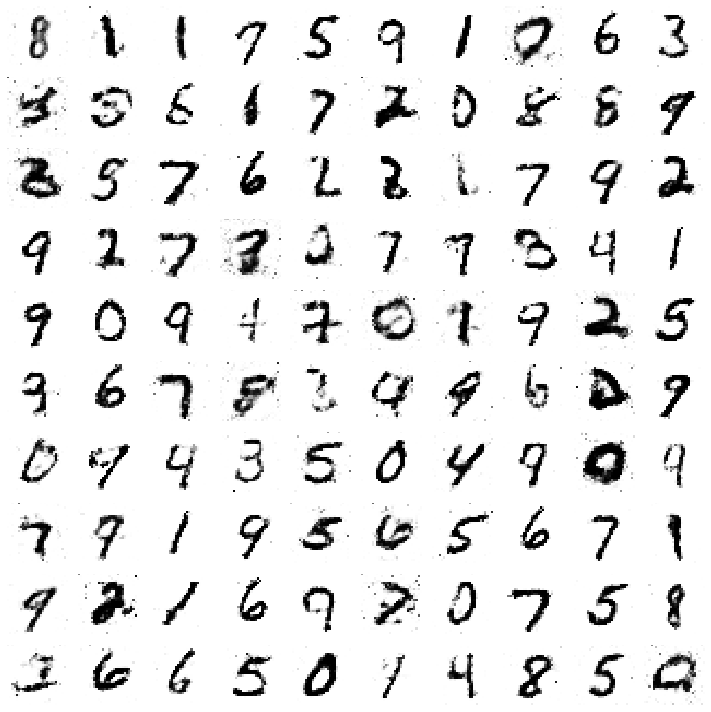

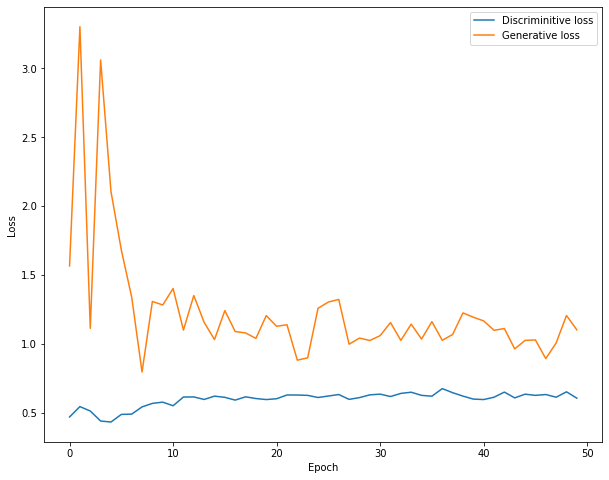

In [12]:
train(50, 128)